In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
import shutil
import imutils
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

from PIL import Image
from keras.utils import to_categorical
from keras.models import load_model

import tensorflow as tf
import seaborn as sns
import zipfile

from sklearn.preprocessing import LabelEncoder

from sklearn.utils import resample
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from pathlib import Path
import plotly.express as px
from google.colab import drive
from glob import glob

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d sovitrath/diabetic-retinopathy-224x224-gaussian-filtered

Dataset URL: https://www.kaggle.com/datasets/sovitrath/diabetic-retinopathy-224x224-gaussian-filtered
License(s): CC0-1.0
100% 425M/427M [00:20<00:00, 29.2MB/s]
100% 427M/427M [00:20<00:00, 21.7MB/s]


In [ ]:
!unzip '/content/diabetic-retinopathy-224x224-gaussian-filtered.zip'

Archive:  /content/diabetic-retinopathy-224x224-gaussian-filtered.zip
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/0024cdab0c1e.png  
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/00cb6555d108.png  
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/0124dffecf29.png  
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/01b3aed3ed4c.png  
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/0369f3efe69b.png  
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/03e25101e8e8.png  
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/04ac765f91a1.png  
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/059bc89df7f4.png  
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/05a5183c92d0.png  
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/0684311afdfc.png  
  inflating: gaussian_filtered_images/gaussian_filtered_imag

In [ ]:

img_dir = '/content/gaussian_filtered_images/gaussian_filtered_images'
image_dir = Path(img_dir)
filepaths = list(image_dir.glob(r'**/*.png'))

labels = []
for filepath in filepaths:
    label = os.path.split(os.path.split(filepath)[0])[1]
    labels.append(label)

In [ ]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')


df = pd.concat([filepaths, labels], axis=1)

df = df.sample(frac=1).reset_index(drop = True)

# df.head(4)
df['Label'].value_counts()

Label
No_DR             1805
Moderate           999
Mild               370
Proliferate_DR     295
Severe             193
Name: count, dtype: int64

In [ ]:

Class_series = pd.Series(df['Label'])
lis = ["No_DR", "Mild", "Moderate", "Severe", "Proliferate_DR"]

DR_or_not = Class_series.value_counts().tolist()

data = {'Severity': lis, 'Count': DR_or_not}
df_plot = pd.DataFrame(data)

fig = px.bar(df_plot, x='Count', y='Severity', orientation='h',
             color='Severity', color_discrete_sequence=["skyblue", "black", "pink", "purple", "blue"],
             title='Percentage among the different Severities of DR')
fig.update_layout(yaxis={'categoryorder': 'total ascending'})
fig.show()



In [ ]:
labelEncoder = LabelEncoder()
labelEncoder.fit(df['Label'])
df['Label']=labelEncoder.transform(df['Label'])

In [ ]:
# from sklearn.utils import resample

n_samples = 400
label_counts = df['Label'].value_counts()
dfs_by_label_resampled = {}

# Iterate through each label
for label in range(5):
    # Check if there are enough samples for resampling
    if label_counts[label] < n_samples:
        # If there are not enough samples, duplicate the existing ones to reach 400

        df_label_resampled = pd.concat([df[df['Label'] == label]] * ((n_samples + label_counts[label] - 1) // label_counts[label]))
        df_label_resampled = df_label_resampled.sample(n_samples, replace=True, random_state=42)
    else:
        # If there are enough samples, resample to get exactly 400
        df_label_resampled = resample(df[df['Label'] == label], n_samples=n_samples, replace=True, random_state=42)

    # Append the resampled DataFrame to the dictionary
    dfs_by_label_resampled[label] = df_label_resampled

# Concatenate the resampled DataFrames
balanced_df = pd.concat(dfs_by_label_resampled.values())

# Shuffle the rows
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
balanced_df['Label'].value_counts()





Label
4    400
0    400
3    400
2    400
1    400
Name: count, dtype: int64

In [ ]:


Class_series = pd.Series(balanced_df['Label'])
lis = ["No_DR", "Mild", "Moderate", "Severe", "Proliferate_DR"]

DR_or_not = Class_series.value_counts().tolist()

data = {'Severity': lis, 'Count': DR_or_not}
df_plot = pd.DataFrame(data)

fig = px.bar(df_plot, x='Count', y='Severity', orientation='h',
             color='Severity', color_discrete_sequence=["skyblue", "black", "pink", "purple", "blue"],
             title='Percentage among the different Severities of DR')
fig.update_layout(yaxis={'categoryorder': 'total ascending'})
fig.show()

In [ ]:
balanced_df['Label']

0       4
1       0
2       3
3       2
4       3
       ..
1995    2
1996    3
1997    2
1998    3
1999    2
Name: Label, Length: 2000, dtype: int64

In [ ]:

directory = '/content/gaussian_filtered_images/gaussian_filtered_images'

# Create a pattern to access all PNG files in the directory
pattern = os.path.join(directory, '*', '*.png')

# Use glob to get all file paths matching the pattern
image_paths = glob(pattern)

size = (224, 224)


def load_image_and_resize(filepath):
        img = Image.open(filepath)
        img = img.resize(size)
        img = np.asarray(img)
        return img

balanced_df['image'] = balanced_df['Filepath'].map(lambda x: load_image_and_resize(x))

In [ ]:
balanced_df['image']

0       [[[128, 128, 124], [128, 128, 132], [129, 128,...
1       [[[128, 128, 128], [128, 128, 128], [128, 128,...
2       [[[128, 128, 128], [128, 128, 128], [128, 128,...
3       [[[128, 128, 128], [128, 128, 128], [128, 128,...
4       [[[128, 125, 134], [128, 128, 128], [128, 128,...
                              ...                        
1995    [[[128, 128, 128], [128, 128, 128], [128, 128,...
1996    [[[131, 127, 127], [128, 132, 131], [125, 124,...
1997    [[[128, 128, 128], [128, 128, 128], [132, 132,...
1998    [[[128, 128, 128], [128, 128, 128], [128, 128,...
1999    [[[132, 132, 132], [132, 132, 132], [124, 124,...
Name: image, Length: 2000, dtype: object

In [ ]:


sampled_images = balanced_df['image'].sample(6, random_state=42)
size = (224, 224)
sampled_images = [Image.fromarray(img).resize(size) for img in sampled_images]

sampled_images = [np.array(img) for img in sampled_images]

fig = make_subplots(rows=2, cols=3, subplot_titles=("Image 1", "Image 2", "Image 3", "Image 4", "Image 5", "Image 6"))

for i, img in enumerate(sampled_images, start=1):
    fig.add_trace(go.Image(z=img), row=(i-1) // 3 + 1, col=(i-1) % 3 + 1)

fig.update_layout(
    title="Sample Images",
    width=800,
    height=600,
    margin=dict(l=20, r=20, t=60, b=20),
)

fig.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:


# Convert images to numpy array
x = np.asarray(balanced_df['image'].to_list())
x = x / 255  # Normalize pixel values

# Convert labels to one-hot encoded format
y = balanced_df['Label']
y = to_categorical(y, num_classes=5)

# Split the data into training, validation, and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)

# Further split the training data into training and validation sets
validation_split = 0.2  # 20% of training data will be used for validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=validation_split, random_state=42, shuffle=True)



In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.densenet import DenseNet121
from keras.callbacks import EarlyStopping,ModelCheckpoint


es = EarlyStopping(monitor='val_accuracy', min_delta = 0.005, patience=10, verbose=1, mode='auto')
mc=ModelCheckpoint(monitor="val_accuracy",filepath='bestmodel.h5',verbose=1,save_best_only=True,mode='auto')
cd = [es,mc]
vgg = DenseNet121(input_shape=(224,224,3),weights='imagenet',include_top=False)
vgg.trainable = False
x = Flatten()(vgg.output)
x = layers.Dense(256,activation='relu')(x)
x = layers.Dropout(0.4)(x)

prediction = Dense(5,activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train ,
                    y_train ,
                    epochs=70 ,
                    batch_size=8,
                    validation_data=(x_val , y_val) ,
                    callbacks=cd
                    )

29084464/29084464 [==============================] - 2s 0us/step


NameError: name 'x_train' is not defined

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']      

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)

# Print the loss and accuracy
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

13/13 [==============================] - 79s 6s/step - loss: 0.4339 - accuracy: 0.8600
Test Loss: 0.4339064359664917
Test Accuracy: 0.8600000143051147


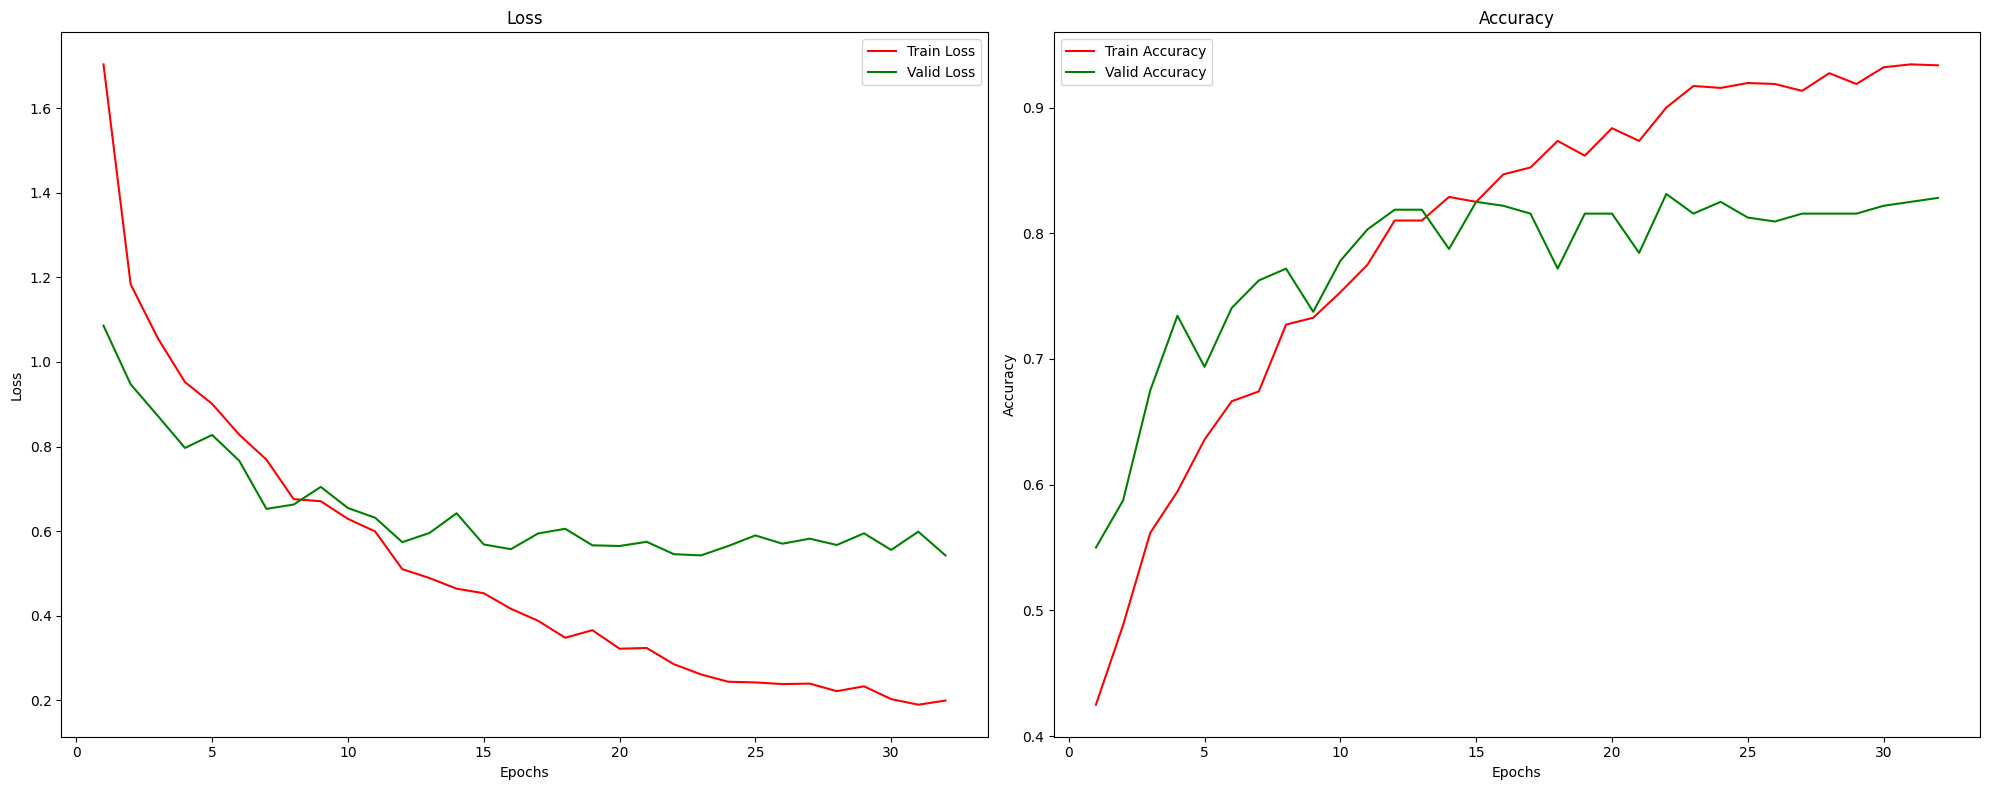

In [ ]:

tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = [i+1 for i in range(len(tr_acc))]

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, 'r', label='Train Loss')
plt.plot(epochs, val_loss, 'g', label='Valid Loss')
plt.title('Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc, 'g', label='Valid Accuracy')
plt.title('Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
model.save('model_86.h5')

In [ ]:
from google.colab import files
files.upload()

Saving 405_left.png to 405_left.png


{'405_left.png': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\xe0\x00\x00\x00\xe0\x08\x02\x00\x00\x00\x95O\xfd\xb6\x00\x00 \x00IDATx\x01\xec\xc1}\xc8\xb6kv\x1e\xf4\xe3X\xeb<\xcf\xeb\xba\x9f\xe7\xdd\xef\x9eI\xd2hK\x0b\xd2hSm\n\xd5\xc6&\xa4\x9a\xa9\xb1\x90B\t\n\xfec\xfd*U0\x16\xa4\xa6\xa1iR\xa3\xc9$\xe4\xc3$\xcdGc(\xd1\xd6&i&M@\n\xa6P+""h\x8b\xadJ\x0b\xb5\xceL\x9c$\x93i\xaaM23\xfb\xe3}\x9e\xfb\xbe\xae\xf3\\k\x1d>3(\x18D(\x15\xe1}\xf7\xde\xbf\x1f\xf1\x9e\xff\x9f\x91\x94\x84\xf7\xfc}!\xde\xf3\x9e\x97\x18\xf1\x9e\xffO\x0c\x9fe\x10`\x80\t \n(\x00\xa2I")%\xde\xf3\xf7\x85x\xcf\xdf\x1b\x03\x01\xc3\x13&d`s\xaf\xfdN\xbf\xf5\xb7\xfc\xc3_\xf8\x05\x9f\xbf\xb7\xb9u\xcdLEq\xf4s\xe2\xcdO?~\xe2\x17\x1f\x7f\xfe\x17\xff\xce[\x9fB@\x10\x850\x18\x80B\xe2=\x7fo\x88\xf7\xfc\xbf3\xb8 B\x02\xc9\x06\xda\xef\xfd\xca/\xfc\xf5\xbf\x16%\xb5\xb6VmR\xce\xe4\xde\xba\xe3\xa4t\xae\xd8\xf7-\xb3\xce\xeb\xcd\xac\xcd\xa2\xb2F\x13\xdc\r>So}\xb2\xfe\xd2\x7f\xfd\xf1YA%\xd0\x81,$\x00\x03\x0b\xc2{\xfe\x1f\x88\xf7\xfcj\x06\n$

In [ ]:

new_model = tf.keras.models.load_model('/content/drive/MyDrive/diabetic_retinopathy/bestmodel.h5')

In [ ]:
Model_evaluation = new_model.evaluate(x_test, y_test)
print(f"%\nAccuracy: {Model_evaluation[1]*100:.4f} %")

13/13 [==============================] - 12s 341ms/step - loss: 0.6167 - accuracy: 0.8350
%
Accuracy: 83.5000 %


In [ ]:
Model_evaluation = new_model.evaluate(x_train, y_train)
print(f"%\nAccuracy: {Model_evaluation[1]*100:.4f} %")

50/50 [==============================] - 286s 6s/step - loss: 0.6411 - accuracy: 0.8031
%
Accuracy: 80.3125 %


In [ ]:
# Model_evaluation = new_model.evaluate(x_test, y_test)
# print(f"%\nAccuracy: {Model_evaluation[1]*100:.4f} %")

13/13 [==============================] - 84s 6s/step - loss: 0.6319 - accuracy: 0.8000
%
Accuracy: 80.0000 %


In [ ]:
y_pred = new_model.predict(x_test)  # Replace 'model' with the name of your trained model

13/13 [==============================] - 3s 92ms/step


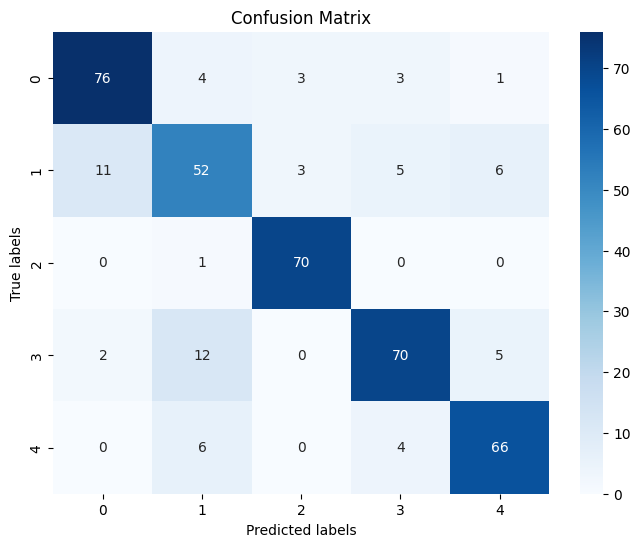

In [ ]:
conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=[str(i) for i in range(5)],
            yticklabels=[str(i) for i in range(5)])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Assuming 'model' is your trained model
model.save('/content/drive/My Drive/my_model_86.h5')


In [ ]:

new_model = tf.keras.models.load_model('/content/drive/My Drive/my_model_86.h5')

In [ ]:
from google.colab import files
files.upload()

Saving 9682_right.png to 9682_right.png


{'9682_right.png': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\xe0\x00\x00\x00\xe0\x08\x02\x00\x00\x00\x95O\xfd\xb6\x00\x00 \x00IDATx\x01\xc4\xc1\xd9\xcf\xae\xe9u\'\xe4\xdfZ\xeb\xbe\x9f\xe1\x1d\xbei\x7f{\xaa]\xb5\xcbU\xe5\xf2P\xb6\x89\x9d\xc4N\x1cu\xa0\xd3\x99\xe9\x81NG\xd0\xa1\x13\xa1VZ\x81\xa0\x06D\xd2\x074\x10q\x84Z\x82\x96\x90\x10\xff\x03\x12g\x1c\xc1\x01B\xb4\x14\xa5\xd3n%\xb1\x13\xdb\xf1X\xc3\x9e\xa7ox\xc7\xe7y\xeea\xad\xc5v5\x89"\xc5!\x83]\xae\xeb"\xfc\x11"\x02\xe0\xee\xf8.b\x82\x03\xee\xf8\xb3\x89\x88\xc1\x0103\xcc\xc1LL\x0483\xc3ev\xf3\xaf\xfd\xc3\xbf\xf5\x83\x9f\xee8\xed//wiSu3\xa0\xea<\xbb\xe6R\xdd\xa6\x9c\x95\xfa\xe8\xf5Z`\xe2\xba\x10\xac\x06,\xa2{\xf0\xa7\x13\x8e\xe2\xb4\xb3~=\xdanBvo\x1b\xdc\\\x82\xb2\x1erT\xaf\x9bI\x8f\x98\x94\xa9j\x98k\xce\xadm\x89=\xd5\x1b!n\x856{\xfb\xd8\xd5\xee\xd6<|}*\xa7\xf3X\x9f\xe6\xda\xc0\x05\x0fF\x7f\xba\x9d\x16QH\xf0h\xa7\xcf*\x07\xaal\xd1Q^\x9d\xcb,p\xd3\xd4\x9b}{o\xc0\x8d%{\xad\xd3\xde\xaci\xa6m\xaa\x8c\xd0R\x9a\xd4\xd9s\x92Q\xf4\xc8\x

In [ ]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf

def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((224, 224))
    img_array = np.array(img)
    img_array = img_array / 255.0
    return img_array

def predict_with_model(image_array, model):
    prediction = model.predict(np.expand_dims(image_array, axis=0))
    return prediction

def convert_and_predict(image_path, model):
    if not os.path.exists(image_path):
        print("Error: Image file not found.")
        return None

    if not image_path.lower().endswith('.png'):
        print("Converting image to PNG format...")
        # Assuming convert_to_png is defined elsewhere
        # convert_to_png(image_path)
        image_path = image_path[:-4] + '.png'

    image_array = preprocess_image(image_path)
    prediction = predict_with_model(image_array, model)
    return prediction

# # Load the model
# new_model = tf.keras.models.load_model('/content/drive/My Drive/my_model_86.h5')

# Example usage:
image_path = '/content/10043_right.png'
prediction = convert_and_predict(image_path, new_model)
print("Prediction:", prediction)

def convert_prediction_to_labels(prediction):
    labels = ["No_DR", "Mild", "Moderate", "Severe", "Proliferate_DR"]
    max_index = np.argmax(prediction)
    predicted_label = labels[max_index]
    return predicted_label

# Example usage:
predicted_label = convert_prediction_to_labels(prediction[0])
print("Predicted Label:", predicted_label)


1/1 [==============================] - 0s 217ms/step
Prediction: [[8.4652013e-01 6.6292281e-03 1.4681171e-01 3.8945505e-05 2.3655627e-08]]
Predicted Label: No_DR


1/1 [==============================] - 0s 461ms/step
Predicted Label: Moderate
No_DR: 4.51%
Mild: 0.01%
Moderate: 95.48%
Severe: 0.00%
Proliferate_DR: 0.00%


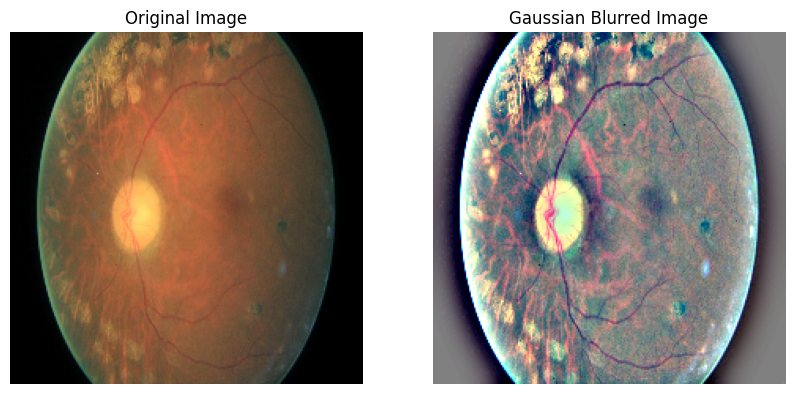

In [ ]:


# # Load your Keras model
# model = load_model('your_model_path.h5')
model=new_model
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((224, 224))
    img_array = np.array(img)
    img_array = img_array / 255.0
    return img_array

def predict_with_model(image_array, model):
    prediction = model.predict(np.expand_dims(image_array, axis=0))
    return prediction

def convert_prediction_to_labels(prediction):
    labels = ["No_DR", "Mild", "Moderate", "Severe", "Proliferate_DR"]
    max_index = np.argmax(prediction)
    predicted_label = labels[max_index]
    return predicted_label

def convert_and_predict(image_path, model):
    if not os.path.exists(image_path):
        print("Error: Image file not found.")
        return None, None

    if not image_path.lower().endswith('.png'):
        print("Converting image to PNG format...")
        convert_to_png(image_path)
        image_path = image_path[:-4] + '.png'

    image_array = preprocess_image(image_path)
    prediction = predict_with_model(image_array, model)
    return prediction, image_array

def apply_gaussian_blur(image_path, sigmaX=10, resize_shape=(224, 224)):
    image = cv2.imread(image_path)
    gaussian = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0,0), sigmaX), -4, 128)
    gaussian_resized = cv2.resize(gaussian, resize_shape)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(gaussian_resized, cv2.COLOR_BGR2RGB))
    plt.title('Gaussian Blurred Image')
    plt.axis('off')

    plt.show()

# Example usage
image_path = "/content/9682_right.png"
prediction, image_array = convert_and_predict(image_path, model)

if prediction is not None and image_array is not None:
    predicted_label = convert_prediction_to_labels(prediction[0])
    print("Predicted Label:", predicted_label)

    confidence_scores = prediction[0]
    labels = ["No_DR", "Mild", "Moderate", "Severe", "Proliferate_DR"]
    for label, score in zip(labels, confidence_scores):
        print(f"{label}: {score*100:.2f}%")

    apply_gaussian_blur(image_path)
